In [1]:
import cv2

from scipy import signal
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import glob
import natsort

In [2]:
def create_skin_mask(img):
    mask = None
    # 얼굴영역 검출 (피부픽셀 검출)
    try:
        low = np.array([0, 133, 77], np.uint8)
        high = np.array([235, 173, 127], np.uint8)
        
        # 얼굴 box를 찾은 후에 피부픽셀만 분리하는 함수 (실시간성을 고려하지 않으면 다른 모델로 대체 가능)
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        mask = cv2.inRange(ycrcb, low, high)
        mask[mask == 255] = 1
    except Exception:
        pass

    return mask

def detrend_signal(arr, win_size):
    # 신호 후처리 함수 (detrend = 추세 를 없앤다.)
    #심박과 관련없는 저주파 와 같은 추세를 없애는 것
    try:
        if arr.ndim == 1:
            arr = np.expand_dims(arr, axis=0)
        n_channel = arr.shape[0]
        norm = signal.convolve2d(np.ones_like(arr), np.ones((n_channel, win_size)), mode='same')
        mean = signal.convolve2d(arr, np.ones((n_channel, win_size)), mode='same') / norm
        return (arr - mean) / (mean + 1e-15)
    except ValueError:
        return arr

def filter_bandpass(arr, srate, band):
    #대역통과필터
    try:
        # 심박수(bpm)의 주파수 도메인은 HZ , 따라서 60을 곱해야 초당이 아닌 분당으로 계산
        nyq = 60 * srate / 2
        coef_vector = signal.butter(5, [band[0] / nyq, band[1] / nyq], 'bandpass')
        return signal.filtfilt(*coef_vector, arr)
    except ValueError:
        return arr
    
def estimate_average_pulserate(arr, srate):
    # 후처리가 완료된 데이터로ㅓ 맥박수 측정
    f, pxx = signal.periodogram(arr, fs=srate, window='hann')
    # 가장 쎈 대역? 주파수 를 찾는다. >> 분당으로 환산한것이 pulserate
    max_peak_idx = np.argmax(pxx)
    pulserate = int(f[max_peak_idx] * 60)
    return min(max(pulserate, band[0]), band[1])

In [3]:
fps = 30
band = [42, 240]
def rgb_extract(face_extract,file_path,band,fps):
    r_signal = []
    g_signal = []
    b_signal = []
    prev_bbox = [0,0,10,10]
    curr_bbox = [0,0,10,10]
    track_toler = 1
    detect_th=0.5
    # 얼굴검출 opencv 사용 
    detector = cv2.dnn.readNetFromTensorflow('model/face_detector.pb',
                                             'model/face_detector.pbtxt')

    times=[]
    group=[]

    #cap = cv2.VideoCapture(1) # 0: 내장캠 1: 외부캠
    #time.sleep(2)

    file_list=glob.glob(os.path.join(file_path,"*.png"))
    file_list = natsort.natsorted(file_list,reverse=False)

    try:
        for file in file_list:
            # 프레임(img) 가져오기
            print("img path: ",file)
            frame = cv2.imread(file, cv2.IMREAD_COLOR)
            
            if face_extract==True:
                # group 설정
#                 g=file.split('\\')[-1].split('_')[1]
#                 group.append(g)
#                 # time 설정
#                 t=file.split('\\')[-1].split('_')[-1][:-4]
#                 times.append(t)
                # 현재 프레임에서 얼굴 검출하기
                blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), [104., 117., 123.], False, False)
                detector.setInput(blob)
                detections = detector.forward()
                print(detections.shape)

                h, w = frame.shape[:2]
                bboxes = [detections[0, 0, i, 3:7] for i in range(detections.shape[2]) if detections[0, 0, i, 2] >= detect_th]
                if len(bboxes) > 0:
                    # bbox가 존재한다면!
                    bboxes = sorted(bboxes, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]), reverse=True)
                    bboxes = [(rect * np.array([w, h, w, h])).astype('int') for rect in bboxes]  # (xs,ys,xe,ye)
                    curr_bbox = bboxes[0] # 얼굴 위치
                    prev_bbox = curr_bbox
                else:
                    # 존재하지 않는다면 즉, 얼굴 검출이 잘 안됐다면
                    curr_bbox = prev_box

                # 얼굴 영역만 잘라내기
                cv2.rectangle(frame, (curr_bbox[0], curr_bbox[1]), (curr_bbox[2], curr_bbox[3]), (0,0,255), 2)
                face = frame[curr_bbox[1]:curr_bbox[3], curr_bbox[0]:curr_bbox[2]]
                img=face
            else:
                img=frame
            
            # remote-PPG 신호 추출하기
            b, g, r = cv2.split(img)
            r_mean = np.mean(r)
            g_mean = np.mean(g)
            b_mean = np.mean(b)
            # 각신호를 담을 list
            r_signal.append(r_mean)
            g_signal.append(g_mean)
            b_signal.append(b_mean)

            # 얼굴 검출 시각화하기
            cv2.imshow('frame', frame)
            if cv2.waitKey(1) == 27:
                break


    finally:
        cv2.destroyAllWindows()
        print("==================================================!!!finish!!!=================================================")

    plt.figure(figsize=(12, 8))
    plt.subplot(3,1,1)
    plt.plot(r_signal, 'r', linewidth=2)
    plt.subplot(3,1,2)
    plt.plot(g_signal, 'g', linewidth=2)
    plt.subplot(3,1,3)
    plt.plot(b_signal, 'b', linewidth=2)
    plt.show()
    
    return r_signal,g_signal,b_signal

def RPPG(r_signal,g_signal,b_signal,band,fps):
    # CHROM 신호 추출
    # chrom이란 움직임에 더 강인하게 하는것.
    # 움직임은 r,g,b동일하게발생/ pulse는 r,g,b각각 다름
    # 이를 이용해 움직임은 제거하고 pulse만 남기도록.

    #보통 신호는 g,r,b순으로 잘보인다. 
    # 심박수를 더 잘보이게 하기위한 후처리
    raw_signal = np.array([r_signal, g_signal, b_signal]).transpose() # 1.세개의 신호를 하나로, 하나의신호화
    detrended = detrend_signal(raw_signal, fps) # 2.추세제거
    detrended = detrended.transpose()
    # 3. 2차원으로 prediction  , 수식에 대해서는 자세히 이해 x
    X = 3 * detrended[0] - 2 * detrended[1] # 4. detrend [] > 0: r, 1: g, 2: b
    Y = 1.5 * detrended[0] + detrended[1] - 1.5 * detrended[2]
    # 5. bandpass filtering
    Xf = filter_bandpass(X, fps, band)
    Yf = filter_bandpass(Y, fps, band)
    alpha = np.std(Xf) / np.std(Yf)
    # 6. pulse 신호로 계산
    pulse = Xf - alpha * Yf
    print("pulse length: ",pulse.shape)

    # 심박수 (심장) / '맥박수' (혈관) >> 우리는 맥박수를 보는것.
    # 맥박수 계산하는 방법
    # 1) 시계열 도메인에서 PPI(peak-to-peak interval) 계산  ==> instant pulse-rate
    # 2) 주파수 도메인에서 maximum power band 검출 ==> average pulse-rate


    # 주파수 스펙트럼 계산
    # 실시간에서는 실시간 fs를 계산해서 파라미터로 넣어줘야함
    f, psd = signal.periodogram(pulse, fs=30, window='hann')
    max_band = np.argmax(psd)
    pr = int(f[max_band] * 60) #분당맥박수
    pr = min(max(pr, band[0]), band[1])


    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    plt.plot(pulse, 'b', linewidth=2)    
    plt.axis('off')
    plt.title('Signal', fontsize=20)

    ax = plt.subplot(1,2,2)
    plt.plot(f, psd, 'k', linewidth=2)    
    plt.xlim([0, 15])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title('Freqency spectrum(PulseRate={})'.format(pr), fontsize=20)

    plt.tight_layout()
    plt.show()
    
    return pulse
    # file_num=subject
    # save_path='D:\\prlab\\ysg\\rppg\\rppg_HRV\\data\\rppg\\'
    # f = open(save_path+'rppg'+str(file_num)+'.csv', 'w', newline='')
    # wr = csv.writer(f)
    # wr.writerow(pulse)
    # wr.writerow(times)
    # wr.writerow(group)
    # f.close()

## 1. face rppg

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1_0.0.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_2_0.032.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_3_0.08.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_4_0.11206666666666668.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_5_0.16006666666666666.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_6_0.20850000000000005.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_7_0.24070000000000003.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_8_0.28813333333333335.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_9_0.3363333333333334.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_10_0.36

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_80_3.3126333333333333.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_81_3.3447.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_82_3.3924666666666674.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_83_3.4247666666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_84_3.472566666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_85_3.5206.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_86_3.5523333333333333.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_87_3.6000666666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_88_3.6480333333333337.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_162_6.736266666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_163_6.784233333333334.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_164_6.832200000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_165_6.864266666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_166_6.9123.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_167_6.9606666666666674.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_168_6.9926666666666675.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_169_7.0406.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_170_7.0726666666666675.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPP

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_243_10.144133333333336.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_244_10.176333333333334.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_245_10.224266666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_246_10.272066666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_247_10.3041.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_248_10.352200000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_249_10.400033333333333.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_250_10.432033333333333.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_251_10.480500000000003.png
(1, 1, 200, 7)
img path:  D:\p

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_320_13.3762.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_321_13.408166666666668.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_322_13.456466666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_323_13.4885.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_324_13.536200000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_325_13.5845.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_326_13.616233333333334.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_327_13.664400000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_328_13.712166666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Dee

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_396_16.560266666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_397_16.592266666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_398_16.6405.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_399_16.688200000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_400_16.7207.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_401_16.768166666666666.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_402_16.800733333333334.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_403_16.8486.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_404_16.896133333333335.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_476_19.904233333333334.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_477_19.952033333333333.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_478_20.00056666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_479_20.03256666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_480_20.0805.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_481_20.128500000000003.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_482_20.160633333333333.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_483_20.208566666666666.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_484_20.2407.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_557_23.312633333333334.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_558_23.3445.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_559_23.392100000000003.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_560_23.4405.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_561_23.4726.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_562_23.520400000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_563_23.552300000000002.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_564_23.600266666666666.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_565_23.648433333333333.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Dee

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_637_26.656233333333336.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_638_26.704533333333334.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_639_26.7525.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_640_26.78436666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_641_26.832233333333335.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_642_26.8642.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_643_26.912166666666668.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_644_26.96066666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_645_26.992066666666666.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_718_30.06456666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_719_30.096533333333333.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_720_30.1442.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_721_30.192.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_722_30.22456666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_723_30.27256666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_724_30.304600000000004.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_725_30.35236666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_726_30.400533333333335.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RP

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_798_33.40806666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_799_33.456133333333334.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_800_33.50423333333333.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_801_33.53626666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_802_33.58423333333334.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_803_33.61606666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_804_33.664.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_805_33.7126.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_806_33.74436666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_879_36.81606666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_880_36.84826666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_881_36.896.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_882_36.92856666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_883_36.97616666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_884_37.024.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_885_37.0563.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_886_37.10410000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_887_37.152566666666665.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_D

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_959_40.16053333333333.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_960_40.20856666666668.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_961_40.25623333333334.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_962_40.2885.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_963_40.336133333333336.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_964_40.368300000000005.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_965_40.416133333333335.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_966_40.46456666666668.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_967_40.49616666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-D

(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1040_43.568400000000004.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1041_43.60026666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1042_43.648633333333336.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1043_43.68023333333334.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1044_43.72850000000001.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1045_43.776133333333334.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1046_43.80863333333333.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1047_43.85626666666667.png
(1, 1, 200, 7)
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1048_43.90453333333333.png
(1, 1, 200, 7)
i

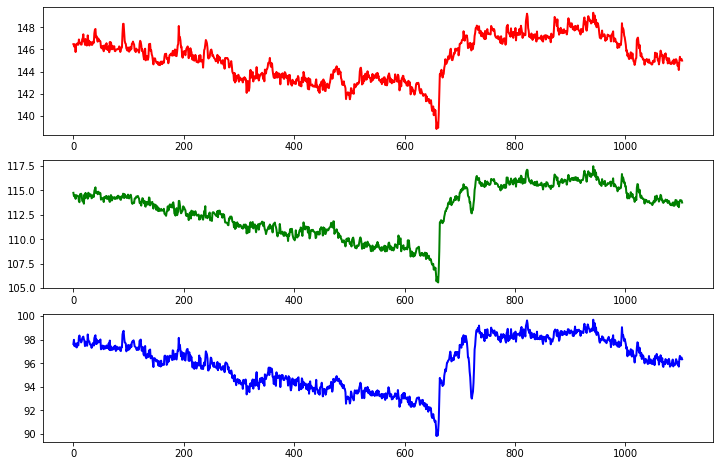

pulse length:  (1104,)


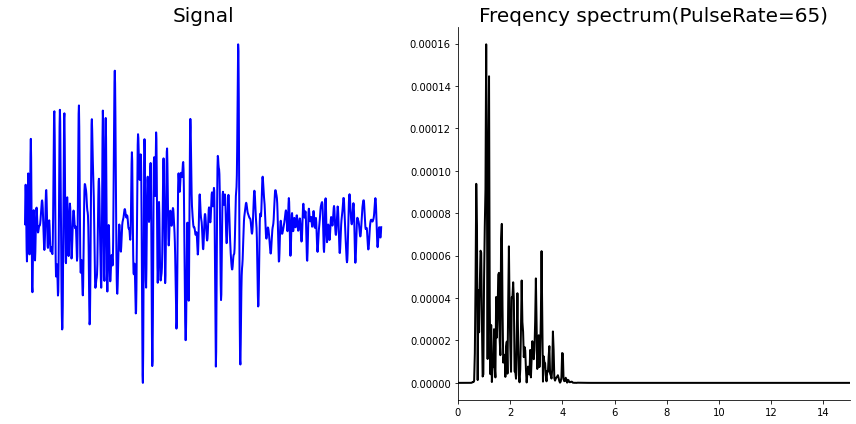

In [60]:
# realface
subject=0
file_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\image\\"+str(subject)+"\\"
r,g,b=rgb_extract(True,file_path,band,fps)
real_face_pulse=RPPG(r,g,b,band,fps)

In [ ]:
# fakeface
subject=1
file_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\image\\"+str(subject)+"\\"
r,g,b=rgb_extract(True,file_path,band,fps)
fake_face_pulse=RPPG(r,g,b,band,fps)

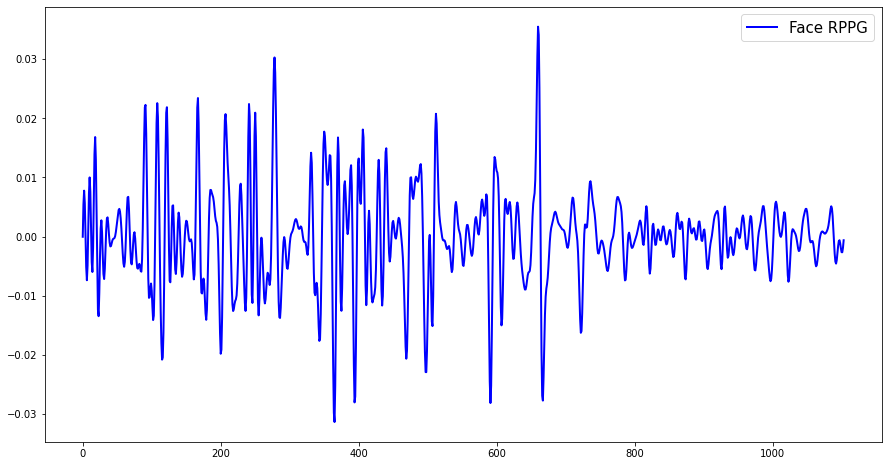

In [61]:
plt.figure(figsize=(15, 8))
plt.plot(real_face_pulse, 'b', linewidth=2,label='Face RPPG')
plt.plot(fake_face_pulse, 'r', linewidth=2,label='Face RPPG')
plt.legend(fontsize=15)
#plt.savefig('fake_face')
plt.show()

realface=face_pulse

## 2. arm rppg

- ROI extraction
- RPPG extraction

### 1. ROI extraction

In [ ]:
# # 1. ycbcr에서 blood fill 알고리즘 사용
# #ycbcr
# def fill(data, start_coords, fill_value):

#     xsize= data.shape[0]
#     ysize=data.shape[1]
#     orig_CR = data[start_coords[0], start_coords[1]][1]
#     orig_CB = data[start_coords[0], start_coords[1]][2] 
#     #print("orig",orig_CR, orig_CB) # Y, CR, CB
#     stack = set(((start_coords[0], start_coords[1]),))
    
#     if fill_value[0] == orig_CR and fill_value[1] == orig_CB:
#         raise ValueError("Filling region with same value "
#                      "already present is unsupported. "
#                      "Did you already fill this region?")

#     while stack:
#         x, y = stack.pop()
#         CR=data[x, y][1]
#         CB=data[x, y][2]
#         if 130<=CR<=173 and 50<=CB<=127:
#             #print('fill_x: ',x,'fill_y: ',y)
            
#             ROI_x.append(x)
#             ROI_y.append(y)
            
#             data[x, y][1] = fill_value[0]
#             data[x, y][2] = fill_value[1]
#             if x > 0:
#                 stack.add((x - 1, y))
#             if x < (xsize - 1):
#                 stack.add((x + 1, y))
#             if y > 0:
#                 stack.add((x, y - 1))
#             if y < (ysize - 1):
#                 stack.add((x, y + 1))
#     data=cv2.rectangle(data,(min(ROI_y),min(ROI_x)),(max(ROI_y),max(ROI_x)),(0,0,255),3)
#     cv2.imshow('fill',data)
#     return ROI_x,ROI_y

# def click_event(event, x, y, flags, param):
#     global ROI_x,ROI_y
#     if event == cv2.EVENT_LBUTTONDOWN:
#         ROI_x=[]
#         ROI_y=[]
#         #print('x: ',x,'y: ',y)
#         print(ycbcr_frame[y][x],frame[y][x])
#         ROI_x,ROI_y=fill(ycbcr_frame,[y,x],[0,0]) # BGR
        
# def find_arm(y_crcb_img):
#     cv2.namedWindow('image')
#     cv2.setMouseCallback('image',click_event)

#     while(1):
#         cv2.imshow('image',y_crcb_img)
#         if cv2.waitKey(0) == 27 :
#             break
#     cv2.destroyAllWindows()

    
# file_num=1    
# file_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\image\\"+str(file_num)+"\\"
# save_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\ROI\\"+str(file_num)+"\\"

# file_list=glob.glob(os.path.join(file_path,"*.png"))
# file_list = natsort.natsorted(file_list,reverse=False)

# frame = cv2.imread(file_list[0], cv2.IMREAD_COLOR)
# ycbcr_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2YCR_CB)
# # 1. 팔영역 ROI찾기
# find_arm(ycbcr_frame)
# # ROI 이미지 크롭, 팔빼고 black처리
# ROI=list(zip(ROI_x,ROI_y))
# for i in range(min(ROI_x),max(ROI_x),1):
#     for j in range(min(ROI_y),max(ROI_y),1):
#         if (i,j)not in ROI:
#             frame[i][j]=0

# arm=frame[min(ROI_x):max(ROI_x)+1,min(ROI_y):max(ROI_y)+1]
# kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
# arm=cv2.erode(arm,kernel)
# arm=cv2.erode(arm,kernel)
# arm_=cv2.erode(arm,kernel)
# arm=cv2.dilate(arm,None)
# arm=cv2.dilate(arm,None)
# arm=cv2.dilate(arm,None)
# cv2.imwrite(save_path+str(0)+'.png',arm)

# # 팔검출 확인
# for (n,file) in enumerate(file_list):
#     if n>0:
#         print('file_num:',n)
#         frame = cv2.imread(file, cv2.IMREAD_COLOR)
# #         ycbcr_frame = cv2.cvtColor(frame,cv2.COLOR_BGR2YCR_CB)
#         # 1. 팔영역 ROI찾기
# #        find_arm(ycbcr_frame)
#         # ROI 이미지 크롭, 팔빼고 black처리
# #        ROI=list(zip(ROI_x,ROI_y))
#         for i in range(min(ROI_x),max(ROI_x),1):
#             for j in range(min(ROI_y),max(ROI_y),1):
#                 if (i,j)not in ROI:
#                     frame[i][j]=0

#         arm=frame[min(ROI_x):max(ROI_x)+1,min(ROI_y):max(ROI_y)+1]
#         cv2.imshow('arm',arm)
#         cv2.imwrite(save_path+str(n)+'.png',arm)
# #        while(1):
        
# #         if cv2.waitKey(0) == 27 :
# #             break
# cv2.destroyAllWindows()

In [9]:
## 2. mouse click
def click_event(event, x, y, flags, param):
    global xmin, ymin,xmax,ymax, drawing, img, ROI_img, drawing_flag

    if event == cv2.EVENT_LBUTTONDOWN:  # 마우스를 누른 상태
        drawing = True
        xmin, ymin = x, y

    elif event == cv2.EVENT_MOUSEMOVE:  # 마우스 이동
        if drawing == True:  # 마우스를 누른 상태 일경우
            img_temp = img.copy()
            cv2.rectangle(img_temp, (xmin, ymin), (x, y), (0, 0, 255), 1)
            cv2.imshow('image', img_temp)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False  # 마우스를 때면 상태 변경
        xmax,ymax=x,y
        cv2.rectangle(img, (xmin, ymin), (x, y), (0, 0, 255), 1)
        cv2.imshow('image', img)
        ROI_img=img[9+1:361,435+1:609]#[ymin+1:y,xmin+1:x]
        cv2.imshow('ROI img',ROI_img)
        print('xmin :{}, ymin:{}, xmax:{}, ymax:{}'.format(xmin, ymin, x, y))
        drawing_flag = True
        
def find_arm(img):
    cv2.namedWindow('image')
    cv2.setMouseCallback('image',click_event)

    while(1):
        cv2.imshow('image',img)
        if cv2.waitKey(0) == 27 :
            break
    cv2.destroyAllWindows()

    

file_num=0   
file_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\image\\"+str(file_num)+"\\"
save_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\ROI\\"+str(file_num)+"\\"

file_list=glob.glob(os.path.join(file_path,"*.png"))
file_list = natsort.natsorted(file_list,reverse=False)

drawing=False
img = cv2.imread(file_list[0], cv2.IMREAD_COLOR)
find_arm(img)
cv2.imwrite(save_path+'0.png',ROI_img)
for (i,file) in enumerate(file_list):
    if i>0:
        print("file_name",file)
        img = cv2.imread(file, cv2.IMREAD_COLOR)
        ymin=9
        xmin=435
        xmax=609
        ymax=361
        ROI_img=img[ymin+1:ymax,xmin+1:xmax]
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)
        cv2.imshow('img',img)
        cv2.imwrite(save_path+str(i)+'.png',ROI_img)
        if cv2.waitKey(1) == 27:
            break
cv2.destroyAllWindows()

xmin :435, ymin:9, xmax:419, ymax:108
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_2_0.032.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_3_0.08.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_4_0.11206666666666668.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_5_0.16006666666666666.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_6_0.20850000000000005.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_7_0.24070000000000003.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_8_0.28813333333333335.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_9_0.3363333333333334.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_10_0.3683.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_11_0.4161666666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_12_0.4486333333333

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_100_4.144633333333333.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_101_4.192566666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_102_4.2243.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_103_4.272433333333334.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_104_4.3044.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_105_4.3523000000000005.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_106_4.400266666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_107_4.4321.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_108_4.4801.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_109_4.5281.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_110_4.560600000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_193_8.048533333333333.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_194_8.0805.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_195_8.128066666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_196_8.176300000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_197_8.2086.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_198_8.256233333333334.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_199_8.2887.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_200_8.336366666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_201_8.384166666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_202_8.416400000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_203_8.464200000000002.png
file_name D:\prlab\ys

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_284_11.856333333333334.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_285_11.904133333333336.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_286_11.936300000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_287_11.984300000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_288_12.032133333333336.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_289_12.064633333333333.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_290_12.112166666666669.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_291_12.160133333333336.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_292_12.1925.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_293_12.240333333333334.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_294_12.27230000

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_377_15.760200000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_378_15.808566666666668.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_379_15.840433333333333.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_380_15.888200000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_381_15.920700000000002.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_382_15.968133333333336.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_383_16.016166666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_384_16.048566666666666.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_385_16.0963.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_386_16.144633333333335.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_387_16.17636666

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_469_19.6161.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_470_19.66453333333334.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_471_19.6961.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_472_19.744600000000002.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_473_19.79256666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_474_19.82466666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_475_19.8722.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_476_19.904233333333334.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_477_19.952033333333333.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_478_20.00056666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_479_20.03256666666667.png
file_name D:\pr

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_570_23.8561.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_571_23.8886.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_572_23.936333333333334.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_573_23.9846.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_574_24.016133333333336.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_575_24.064600000000002.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_576_24.112633333333335.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_577_24.14466666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_578_24.192633333333333.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_579_24.22456666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_580_24.272600000000004.png
file_name D:

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_671_28.0805.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_672_28.12816666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_673_28.1761.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_674_28.208266666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_675_28.2561.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_676_28.304533333333335.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_677_28.336233333333336.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_678_28.38436666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_679_28.416266666666672.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_680_28.464233333333336.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_681_28.51216666666667.png
file_name D:\

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_770_32.2406.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_771_32.28853333333333.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_772_32.32063333333333.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_773_32.368566666666666.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_774_32.4007.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_775_32.44853333333334.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_776_32.4961.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_777_32.5283.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_778_32.57613333333334.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_779_32.624500000000005.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_780_32.6562.png
file_name D:\prlab\ysg\rppg\RPPG-Dee

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_861_36.04806666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_862_36.09630000000001.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_863_36.144200000000005.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_864_36.176233333333336.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_865_36.2242.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_866_36.2721.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_867_36.3046.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_868_36.352333333333334.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_869_36.3845.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_870_36.432.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_871_36.480533333333334.png
file_name D:\prlab\ysg\rppg\RPPG-De

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_954_39.952266666666674.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_955_40.00056666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_956_40.03246666666668.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_957_40.080600000000004.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_958_40.12856666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_959_40.16053333333333.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_960_40.20856666666668.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_961_40.25623333333334.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_962_40.2885.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_963_40.336133333333336.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_964_40.36830000000000

file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1053_44.1126.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1054_44.144600000000004.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1055_44.192433333333334.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1056_44.240566666666666.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1057_44.2723.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1058_44.32013333333334.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1059_44.35256666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1060_44.40006666666667.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1061_44.448100000000004.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1062_44.48063333333334.png
file_name D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\image\0\frame_1063_44.528533333333

### 2. RPPG

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\0.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\1.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\2.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\3.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\4.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\5.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\6.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\7.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\8.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\9.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\10.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\11.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\12.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\13.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\14.png
img path:  D:\prlab\

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\125.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\126.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\127.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\128.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\129.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\130.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\131.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\132.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\133.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\134.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\135.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\136.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\137.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\138.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\139

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\258.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\259.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\260.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\261.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\262.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\263.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\264.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\265.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\266.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\267.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\268.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\269.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\270.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\271.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\272

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\389.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\390.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\391.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\392.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\393.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\394.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\395.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\396.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\397.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\398.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\399.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\400.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\401.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\402.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\403

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\522.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\523.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\524.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\525.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\526.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\527.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\528.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\529.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\530.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\531.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\532.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\533.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\534.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\535.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\536

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\654.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\655.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\656.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\657.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\658.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\659.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\660.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\661.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\662.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\663.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\664.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\665.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\666.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\667.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\668

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\784.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\785.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\786.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\787.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\788.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\789.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\790.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\791.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\792.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\793.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\794.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\795.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\796.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\797.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\798

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\916.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\917.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\918.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\919.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\920.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\921.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\922.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\923.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\924.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\925.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\926.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\927.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\928.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\929.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\930

img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\1047.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\1048.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\1049.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\1050.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\1051.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\1052.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\1053.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\1054.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\1055.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\1056.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\1057.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\1058.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\1059.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detection\ROI\0\1060.png
img path:  D:\prlab\ysg\rppg\RPPG-Deepfake_Detec

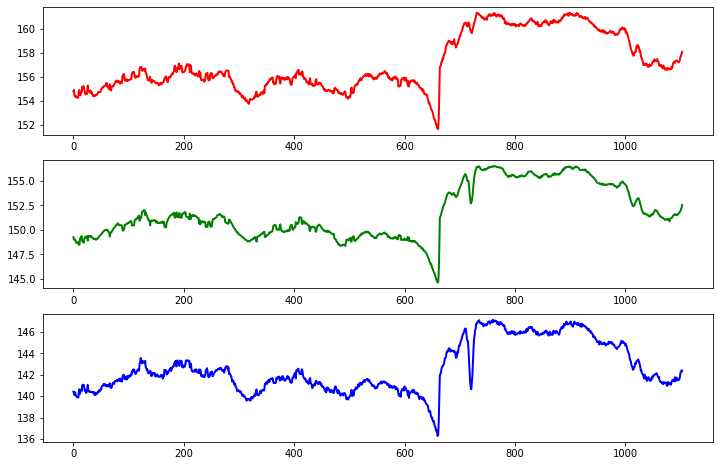

pulse length:  (1104,)


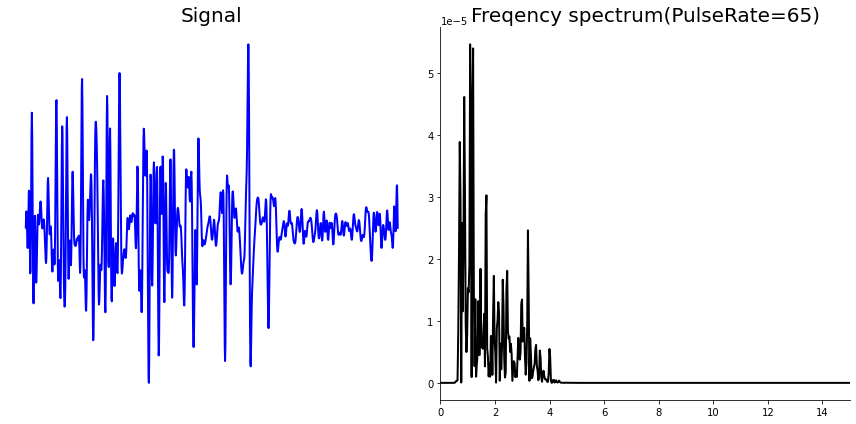

In [10]:
# real arm
subject=0
file_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\ROI\\"+str(subject)+"\\"
r,g,b=rgb_extract(False,file_path,band,fps)
real_arm_pulse=RPPG(r,g,b,band,fps)

In [ ]:
# fake arm
subject=1
file_path="D:\\prlab\\ysg\\rppg\\RPPG-Deepfake_Detection\\ROI\\"+str(subject)+"\\"
r,g,b=rgb_extract(False,file_path,band,fps)
fake_arm_pulse=RPPG(r,g,b,band,fps)

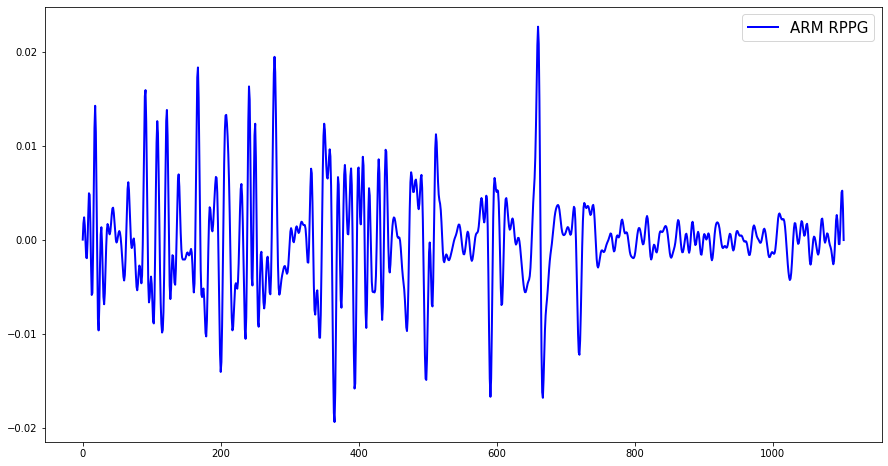

In [66]:
plt.figure(figsize=(15, 8))
plt.plot(real_arm_pulse, 'b', linewidth=2,label='Real ARM RPPG')
plt.plot(fake_arm_pulse, 'b', linewidth=2,label='Fake ARM RPPG')
plt.legend(fontsize=15)
#plt.savefig('fake_neck')
plt.show()

#fakeneck=arm_pulse

## Arm & Face 신호 추가처리

In [9]:
from sklearn.preprocessing import MinMaxScaler
import heartpy as hp
arm_pulse=pulse

def normalization(ppg_data):
    ppg_data=np.array(ppg_data)
    # MinMaxScaler객체 생성
    scaler = MinMaxScaler()
    # MinMaxScaler 로 데이터 셋 변환. fit() 과 transform() 호출.
    scaler.fit(ppg_data.reshape(len(ppg_data),1))
    ppg_scaled = scaler.transform(ppg_data.reshape(len(ppg_data),1))
    #print(type(ppg_scaled))
    #print(ppg_scaled.shape) > len(ppg_data),1
#     plt.plot(ppg_scaled)
#     plt.show()
    return ppg_scaled.reshape(len(ppg_data))

def preprocessing(ppg_data, cut_l, cut_h, sr):
    filtered = hp.filter_signal(ppg_data, cutoff=cut_l, sample_rate=sr, order=3, filtertype='lowpass')
    filtered = hp.filter_signal(filtered, cutoff=cut_h, sample_rate=sr, order=3, filtertype='highpass')
    return filtered

face_pulse_=normalization(face_pulse)
arm_pulse_=preprocessing(arm_pulse,1.5,0.8,30)
arm_pulse_=normalization(arm_pulse_)

face_f, face_psd = signal.periodogram(face_pulse_, fs=30, window='hann')
max_band = np.argmax(face_psd)
pr = int(face_f[max_band] * 60) #분당맥박수
face_pr = min(max(pr, band[0]), band[1])

arm_f, arm_psd = signal.periodogram(arm_pulse_, fs=30, window='hann')
max_band = np.argmax(arm_psd)
pr = int(arm_f[max_band] * 60) #분당맥박수
arm_pr = min(max(pr, band[0]), band[1])

print(face_pr,arm_pr)

78 70


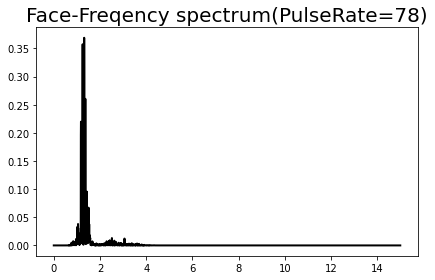

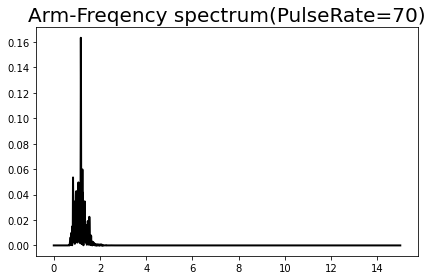

In [84]:
plt.plot(face_f, face_psd, 'k', linewidth=2) 
plt.title('Face-Freqency spectrum(PulseRate={})'.format(face_pr), fontsize=20)
plt.tight_layout()
plt.show()


plt.plot(arm_f, arm_psd, 'k', linewidth=2) 
plt.title('Arm-Freqency spectrum(PulseRate={})'.format(arm_pr), fontsize=20)
plt.tight_layout()
plt.show()

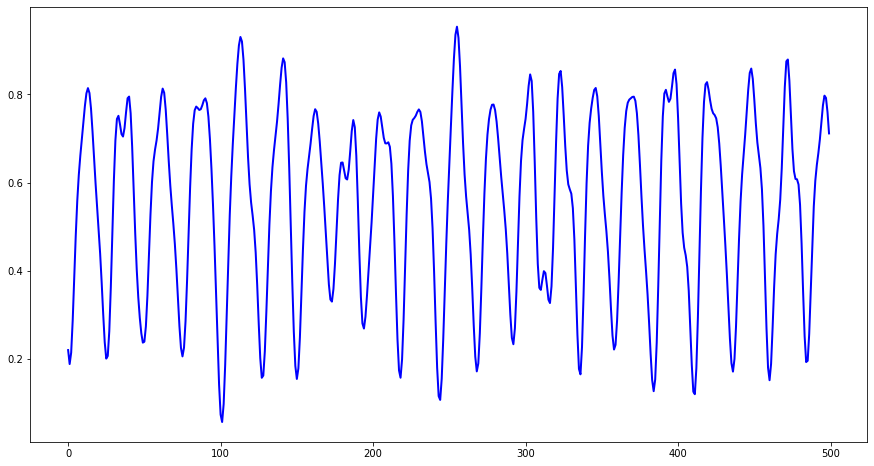

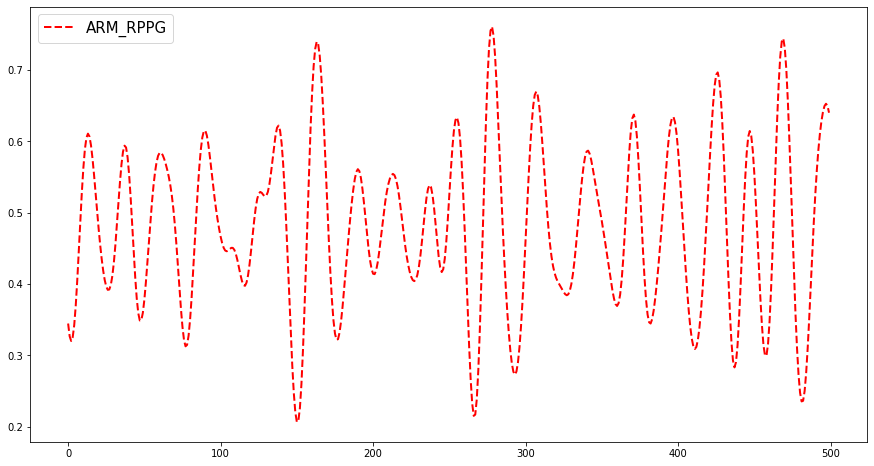

In [11]:
plt.figure(figsize=(15, 8))
plt.plot(face_pulse_[1500:2000], 'b', linewidth=2,label='Face RPPG')
plt.plot(arm_pulse_[1500:2000], 'r', linestyle='--',linewidth=2,label='ARM_RPPG') 
plt.legend(fontsize=15)
plt.show()